# **Introduction**
To effectively evaluate the performance of the DiffusionOT model, in this tutorial,we validated it on a two-gene regulatory network model known as the MISA model, which includes mutual inhibition between the two genes and self-activation, modeled using Hill function.

## Load data and model

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import sys
sys.path.append('C:\\Users\\JTliu\\Desktop\\DiffusionOT-main\\')
from utility import *
args = create_args()

random.seed(args.seed)
torch.manual_seed(args.seed)

#device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')#torch.cuda.device_count()
device = torch.device('cpu')#torch.cuda.device_count()
# load dataset
data_train = loaddata(args,device)
integral_time = args.timepoints

time_pts = range(len(data_train))
leave_1_out = []
train_time = [x for i,x in enumerate(time_pts) if i!=leave_1_out]

# model
func = RUOT(in_out_dim=data_train[0].shape[1], hidden_dim=args.hidden_dim,n_hiddens=args.n_hiddens,activation=args.activation,d=args.d).to(device)
func.apply(initialize_weights)

# configure training options
options = {}
options.update({'method': 'Dopri5'})
options.update({'h': None})
options.update({'rtol': 1e-3})
options.update({'atol': 1e-5})
options.update({'print_neval': False})
options.update({'neval_max': 1000000})
options.update({'safety': None})
optimizer = optim.Adam(func.parameters(), lr=args.lr, weight_decay=0.01)
lr_adjust = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[
                                            args.niters-400, args.niters-200], gamma=0.5, last_epoch=-1)
mse = nn.MSELoss()
LOSS = []
L2_1 = []
L2_2 = []
L2_3 = []
L2_4 = []
Trans = []
Sigma = []

Name of the data set. Options: EMT; Mouse; Zebrafish; Spatial; MISA (default: MISA):  
Time points of data (default: 0,1,2,6):  
Number of training iterations (default: 5000):  2000
Learning rate (default: 3e-3):  
Number of sampling points per epoch (default: 100):  
Dimension of the hidden layer (default: 16):  
Number of hidden layers (default: 4):  
Activation function (default: Tanh):  
GPU device index (default: 0):  
Input Files Directory (default: Input/):  C:\\Users\\JTliu\\Desktop\\DiffusionOT-main\\Input
Output Files Directory (default: Output/):  C:\\Users\\JTliu\\Desktop\\DiffusionOT-main\\Output
Random seed (default: 1):  
Diffusion coefficient (default: 0.001):  


## Pretrain the score

In [3]:
# fix func.hyper_net1，hyper_net2
fixed_layers = [func.hyper_net1, func.hyper_net2]
func.d.requires_grad = False#True
for layer in fixed_layers:
    for param in layer.parameters():
        param.requires_grad = False
optimizer = optim.Adam(filter(lambda p: p.requires_grad, func.parameters()), lr=args.lr, weight_decay=0.01)

sigma_now = 1
loss_score_all=[]
for itr in range(1, 200 + 1):#args.niters
    optimizer.zero_grad()     
    loss_score= pre_train_score(mse,func,args,data_train,train_time,integral_time,sigma_now,device,itr)
    loss_score.backward()
    optimizer.step()
    print('Pre_train_score_Iter: {}, loss: {:.4f}'.format(itr, loss_score.item()))
    loss_score_all.append(loss_score.item())
            
##save pre_train result        
ckpt_path = os.path.join(args.save_dir, 'ckpt_{}_score.pth'.format(args.dataset))
torch.save({'func_state_dict': func.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()}, ckpt_path)
print('Iter {}, Stored ckpt at {}'.format(itr, ckpt_path))    

Pre_train_score_Iter: 1, loss: 2.2898
Pre_train_score_Iter: 2, loss: 0.9155
Pre_train_score_Iter: 3, loss: -0.1634
Pre_train_score_Iter: 4, loss: -1.0500
Pre_train_score_Iter: 5, loss: -1.8597
Pre_train_score_Iter: 6, loss: -2.5871
Pre_train_score_Iter: 7, loss: -3.2550
Pre_train_score_Iter: 8, loss: -3.7879
Pre_train_score_Iter: 9, loss: -4.5016
Pre_train_score_Iter: 10, loss: -4.9634
Pre_train_score_Iter: 11, loss: -5.3558
Pre_train_score_Iter: 12, loss: -6.2681
Pre_train_score_Iter: 13, loss: -6.3940
Pre_train_score_Iter: 14, loss: -6.9043
Pre_train_score_Iter: 15, loss: -7.3145
Pre_train_score_Iter: 16, loss: -7.3357
Pre_train_score_Iter: 17, loss: -7.7702
Pre_train_score_Iter: 18, loss: -9.0761
Pre_train_score_Iter: 19, loss: -8.7493
Pre_train_score_Iter: 20, loss: -8.9600
Pre_train_score_Iter: 21, loss: -8.7706
Pre_train_score_Iter: 22, loss: -10.1237
Pre_train_score_Iter: 23, loss: -9.8978
Pre_train_score_Iter: 24, loss: -10.3752
Pre_train_score_Iter: 25, loss: -9.4414
Pre_train

## Pretrain the velocity and growth

In [4]:
fixed_layers = [func.hyper_net3]
train_layers = [func.hyper_net1, func.hyper_net2]
func.d.requires_grad = False#True
for layer in fixed_layers:
    for param in layer.parameters():
        param.requires_grad = False
for layer in train_layers:
    for param in layer.parameters():
        param.requires_grad = True
optimizer = optim.Adam(filter(lambda p: p.requires_grad, func.parameters()), lr=args.lr, weight_decay=0.01)#args.lr
sigma_now = 1
l=1
for itr in range(1,  100+ 1):#args.niters
    optimizer.zero_grad()
    loss, sigma_now, L2_value3,L2_value4= pre_train_model(mse,func,args,data_train,train_time,integral_time,sigma_now,options,device,itr)
    loss.backward()
    optimizer.step()
    lr_adjust.step()
    l=loss.item()
    LOSS.append(loss.item())
    Sigma.append(sigma_now)
    L2_3.append(L2_value3.tolist())     
    print('Iter: {}, loss: {:.4f}'.format(itr, loss.item()))
        
ckpt_path = os.path.join(args.save_dir, 'ckpt_{}_pre.pth'.format(args.dataset,itr))
torch.save({'func_state_dict': func.state_dict()}, ckpt_path)
print('Iter {}, Stored ckpt at {}'.format(itr, ckpt_path))

Iter: 1, loss: 9.6316
Iter: 2, loss: 7.5548
Iter: 3, loss: 5.8213
Iter: 4, loss: 4.6077
Iter: 5, loss: 4.1124
Iter: 6, loss: 4.2423
Iter: 7, loss: 4.3701
Iter: 8, loss: 4.5833
Iter: 9, loss: 4.6241
Iter: 10, loss: 4.5294
Iter: 11, loss: 4.3845
Iter: 12, loss: 3.9527
Iter: 13, loss: 3.5944
Iter: 14, loss: 3.2881
Iter: 15, loss: 3.1952
Iter: 16, loss: 3.2494
Iter: 17, loss: 3.3583
Iter: 18, loss: 3.3893
Iter: 19, loss: 3.3903
Iter: 20, loss: 3.2146
Iter: 21, loss: 3.0058
Iter: 22, loss: 2.7973
Iter: 23, loss: 2.9051
Iter: 24, loss: 2.9770
Iter: 25, loss: 3.0909
Iter: 26, loss: 3.0028
Iter: 27, loss: 2.8753
Iter: 28, loss: 2.8454
Iter: 29, loss: 2.8017
Iter: 30, loss: 2.7717
Iter: 31, loss: 2.8445
Iter: 32, loss: 2.8413
Iter: 33, loss: 2.7837
Iter: 34, loss: 2.7694
Iter: 35, loss: 2.7622
Iter: 36, loss: 2.8012
Iter: 37, loss: 2.7656
Iter: 38, loss: 2.7898
Iter: 39, loss: 2.7625
Iter: 40, loss: 2.7823
Iter: 41, loss: 2.6952
Iter: 42, loss: 2.6819
Iter: 43, loss: 2.6885
Iter: 44, loss: 2.73

## Training the total loss

In [5]:
fixed_layers = [func.hyper_net3]
train_layers = [func.hyper_net1, func.hyper_net2,func.hyper_net3]
func.d.requires_grad = False#True
for layer in fixed_layers:
    for param in layer.parameters():
        param.requires_grad = False
for layer in train_layers:
    for param in layer.parameters():
        param.requires_grad = True
optimizer = optim.Adam(filter(lambda p: p.requires_grad, func.parameters()), lr=args.lr, weight_decay=0.01)#args.lr
sigma_now = 0.25
D_all=[]
for itr in range(1, args.niters + 1):#args.niters
    optimizer.zero_grad()
    loss, loss1, sigma_now, L2_value1, L2_value2, L2_value3, L2_value4= train_model(mse,func,args,data_train,train_time,integral_time,sigma_now,options,device,itr)
    loss.backward()
    optimizer.step()
    lr_adjust.step()      
    LOSS.append(loss.item())
    Trans.append(loss1[-1].mean(0).item())
    Sigma.append(sigma_now)
    L2_1.append(L2_value1.tolist())
    L2_2.append(L2_value2.tolist())
    L2_3.append(L2_value3.tolist())
    L2_4.append(L2_value4.tolist())
    print('Iter: {}, loss: {:.4f}'.format(itr, loss.item()))
    if itr % 500 == 0:
        D_t=diffusion_fit(func,args,data_train,train_time,integral_time,device,time_tt=0.5)
        D=torch.mean(D_t)
        D_all.append(D.detach().cpu().numpy())
        ckpt_path = os.path.join(args.save_dir, 'ckpt_{}_itr{}.pth'.format(args.dataset,itr))
        torch.save({'func_state_dict': func.state_dict()}, ckpt_path)
        print('Iter {}, Stored ckpt at {}'.format(itr, ckpt_path))
            
    if (itr%100 == 0) and (itr<500):
        D_t=diffusion_fit(func,args,data_train,train_time,integral_time,device,time_tt=0.5)
        D=torch.mean(D_t)
        D_all.append(D.detach().cpu().numpy())
                
        func.d=torch.nn.Parameter(D)
        ckpt_path = os.path.join(args.save_dir, 'ckpt_{}_itr{}.pth'.format(args.dataset,itr))
        torch.save({'func_state_dict': func.state_dict()}, ckpt_path)
        print('Iter {}, Stored ckpt at {}'.format(itr, ckpt_path))  

ckpt_path = os.path.join(args.save_dir, 'ckpt_{}.pth'.format(args.dataset))
torch.save({
    'func_state_dict': func.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'LOSS':LOSS,
    'TRANS':Trans,
    'L2_1': L2_1,
    'L2_2': L2_2,
    'L2_3': L2_3,
    'L2_4': L2_4,
    'Sigma': Sigma,
    'D':D_all,
    }, ckpt_path)
print('Stored ckpt at {}'.format(ckpt_path))

Iter: 1, loss: 144780.4375
Iter: 2, loss: 2530.7371
Iter: 3, loss: 196.0783
Iter: 4, loss: 510.3035
Iter: 5, loss: 775.3971
Iter: 6, loss: 966.3722
Iter: 7, loss: 1068.8032
Iter: 8, loss: 1187.1312
Iter: 9, loss: 1268.2958
Iter: 10, loss: 1348.2738
Iter: 11, loss: 1417.6224
Iter: 12, loss: 1489.0861
Iter: 13, loss: 1451.9381
Iter: 14, loss: 1535.5198
Iter: 15, loss: 1575.6357
Iter: 16, loss: 1554.2462
Iter: 17, loss: 1587.2581
Iter: 18, loss: 1606.0433
Iter: 19, loss: 1645.4427
Iter: 20, loss: 1624.7327
Iter: 21, loss: 1647.7043
Iter: 22, loss: 1686.8430
Iter: 23, loss: 1674.6360
Iter: 24, loss: 1674.5626
Iter: 25, loss: 1703.2059
Iter: 26, loss: 1709.7319
Iter: 27, loss: 1688.3610
Iter: 28, loss: 1713.2136
Iter: 29, loss: 1724.4594
Iter: 30, loss: 1692.9397
Iter: 31, loss: 1743.7065
Iter: 32, loss: 1709.8534
Iter: 33, loss: 1694.8474
Iter: 34, loss: 1747.0637
Iter: 35, loss: 1751.3820
Iter: 36, loss: 1718.2589
Iter: 37, loss: 1678.2009
Iter: 38, loss: 1718.0618
Iter: 39, loss: 1675.49

## Visualization

In [2]:
func = RUOT(in_out_dim=data_train[0].shape[1], hidden_dim=args.hidden_dim,n_hiddens=args.n_hiddens,activation=args.activation,d =args.d).to(device)
# load trained networks
if args.save_dir is not None:
    if not os.path.exists(args.save_dir):
        os.makedirs(args.save_dir)
    ckpt_path = os.path.join(args.save_dir, 'ckpt_MISA.pth')#'ckpt6_MISA3_D_{:.3f}.pth'.format(D0) 'ckpt6_MISA4.pth''ckpt_EMT.pth'ckpt_Simulation_itr2000_D_0.040
    if os.path.exists(ckpt_path):
        checkpoint = torch.load(ckpt_path,map_location=torch.device('cpu'))
        func.load_state_dict(checkpoint['func_state_dict'])
        print('Loaded ckpt from {}'.format(ckpt_path))

Loaded ckpt from C:\\Users\\JTliu\\Desktop\\DiffusionOT-main\\Output\ckpt_MISA.pth


## Cell velocity

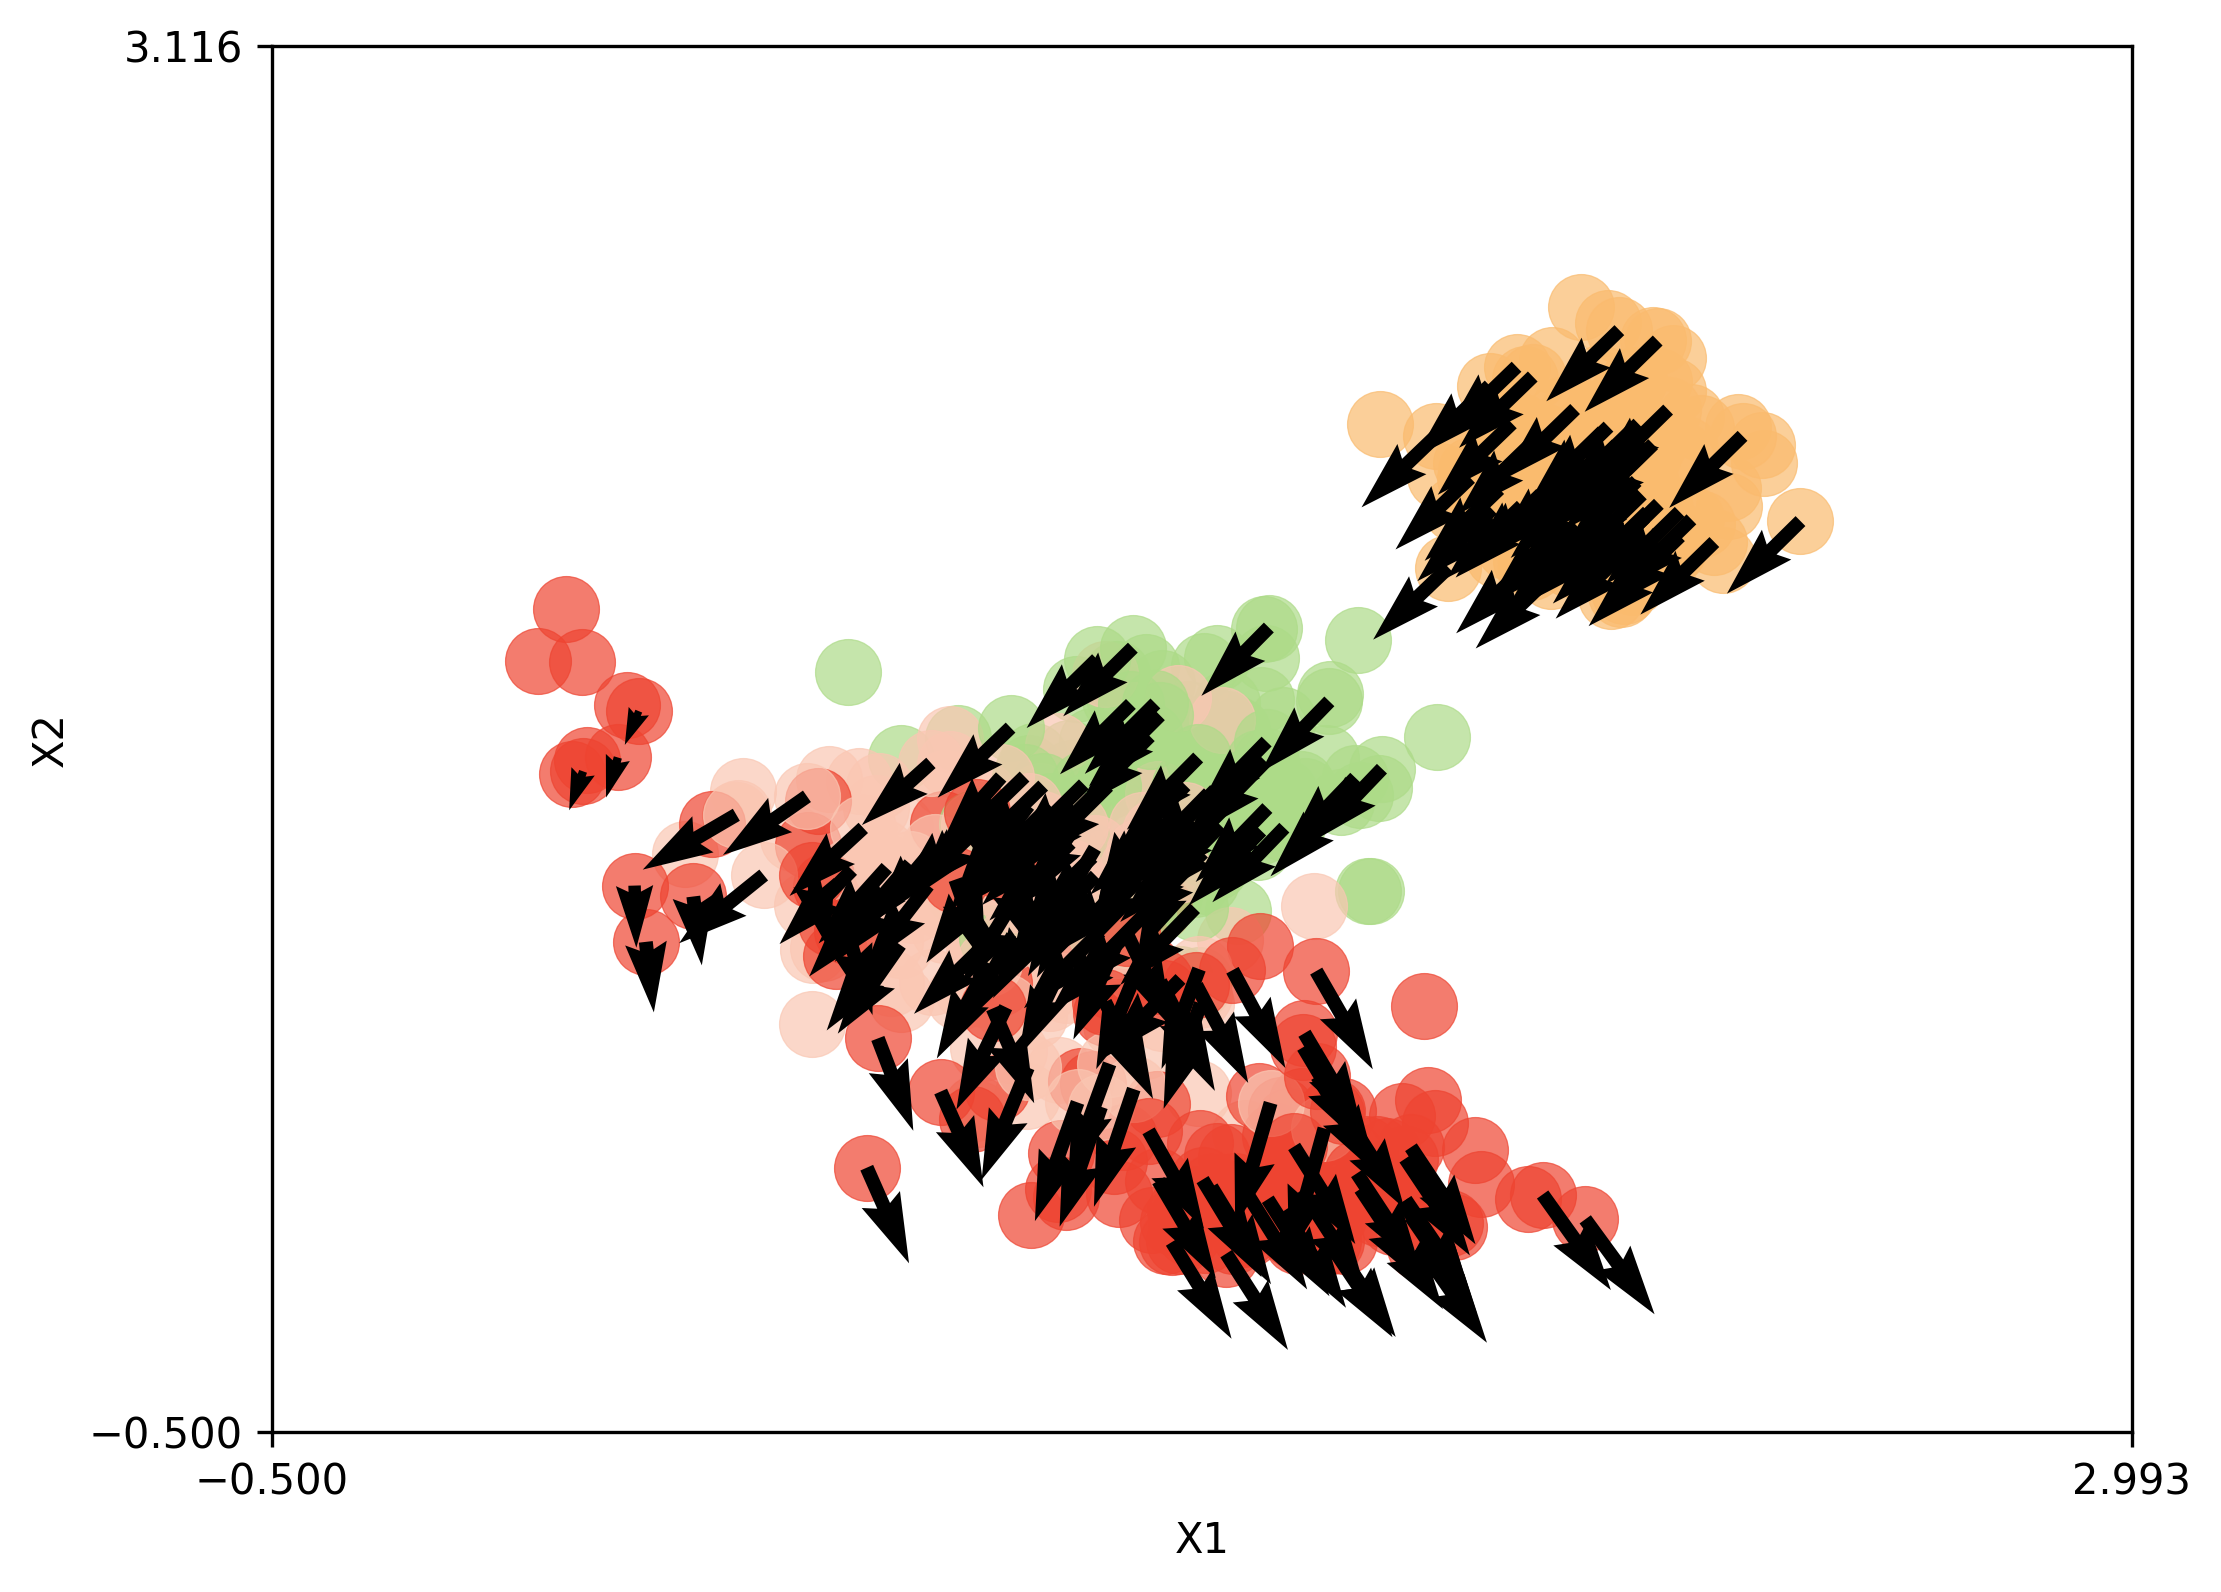

In [3]:
plot_2d_v(func,data_train,train_time,integral_time,args,device)  

## Plot trajectory and growth

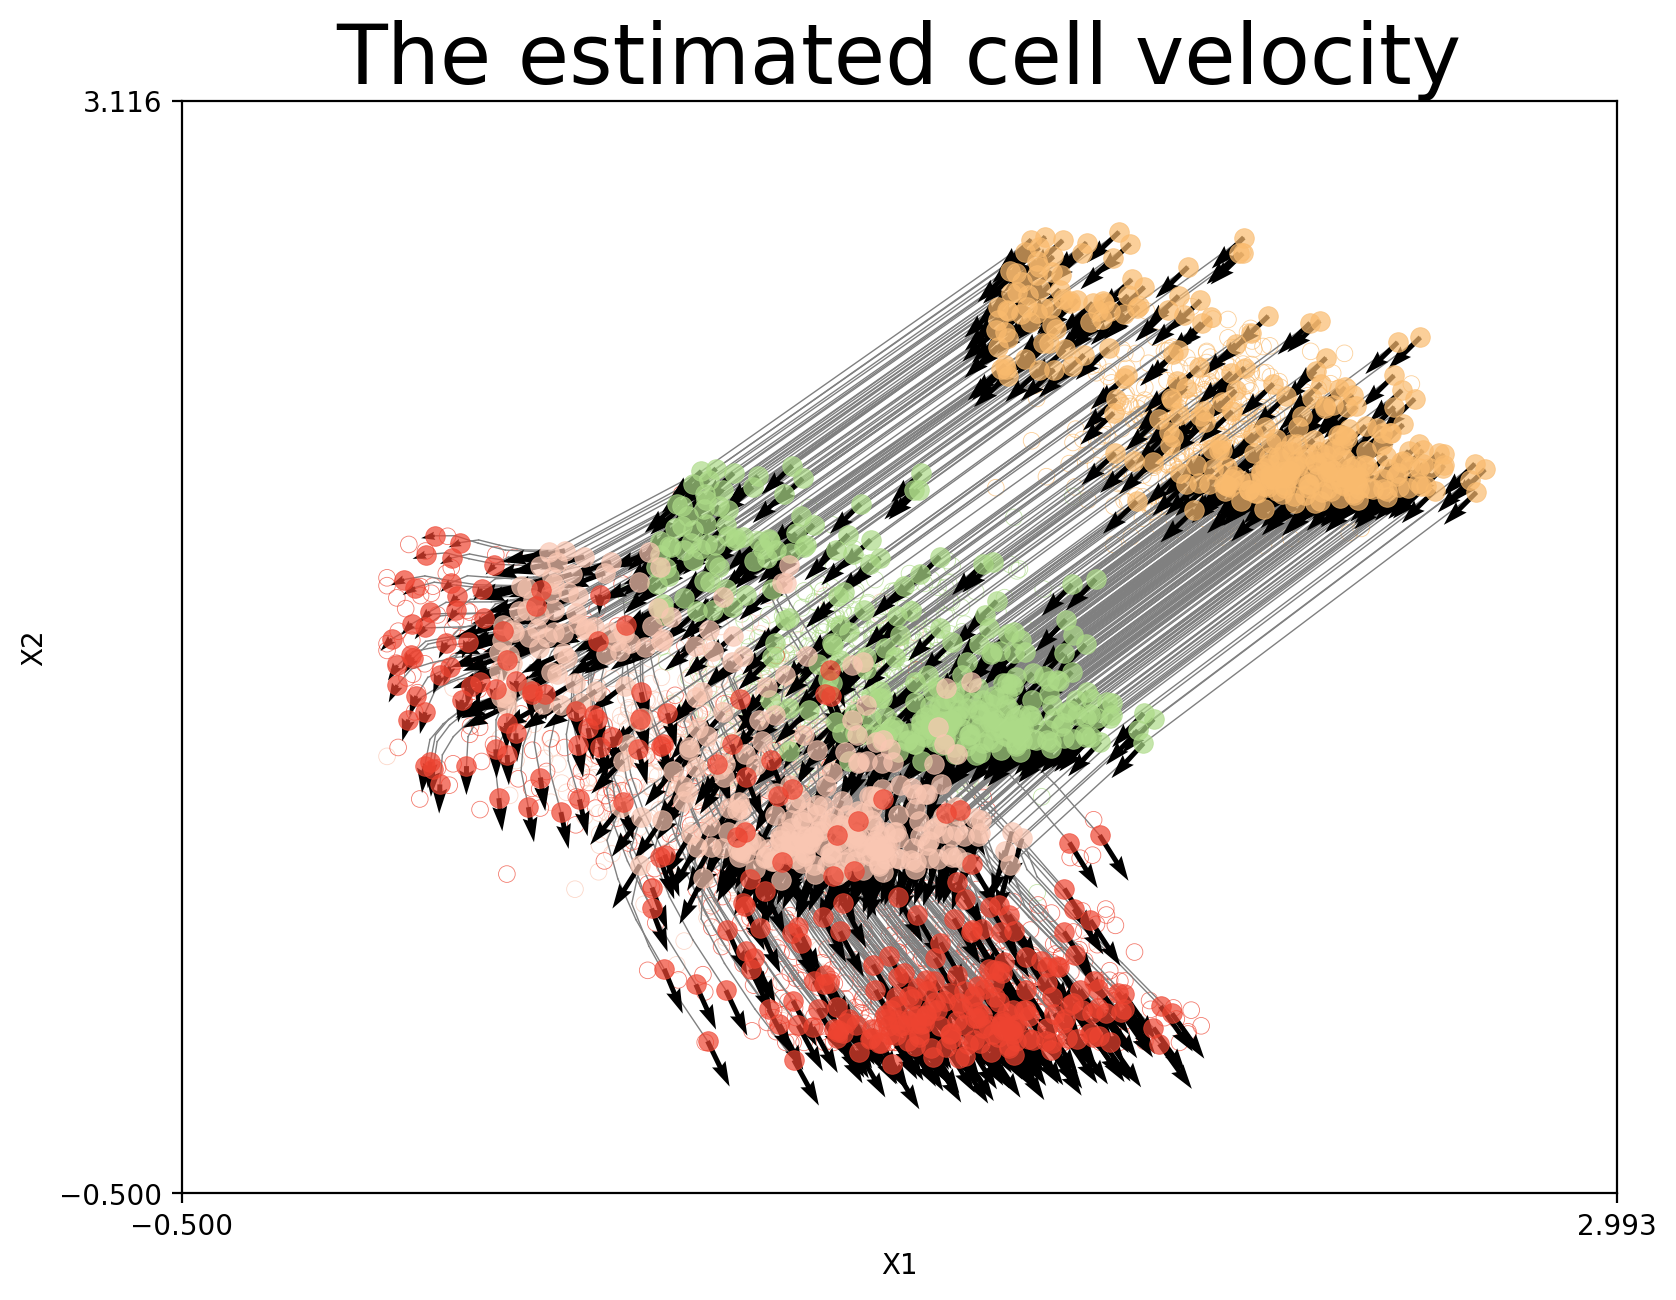

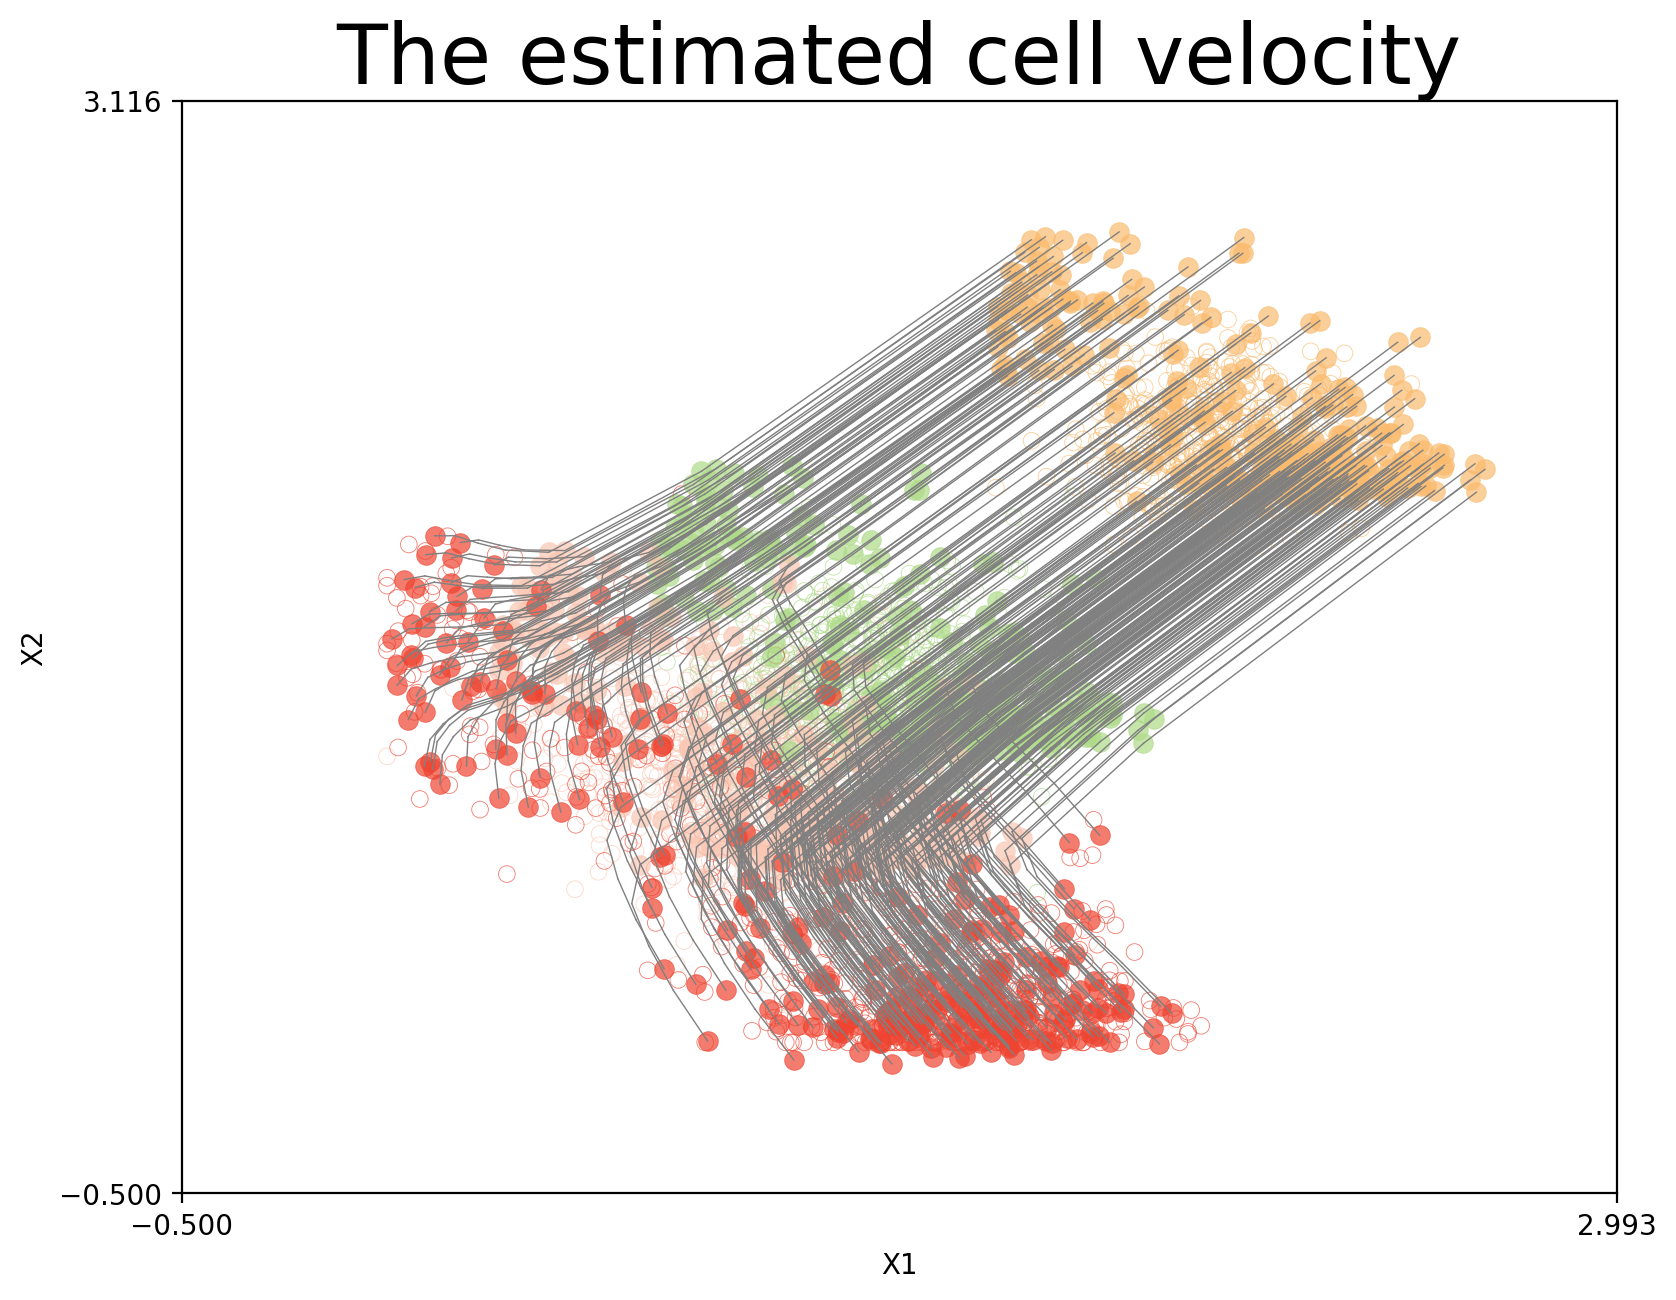

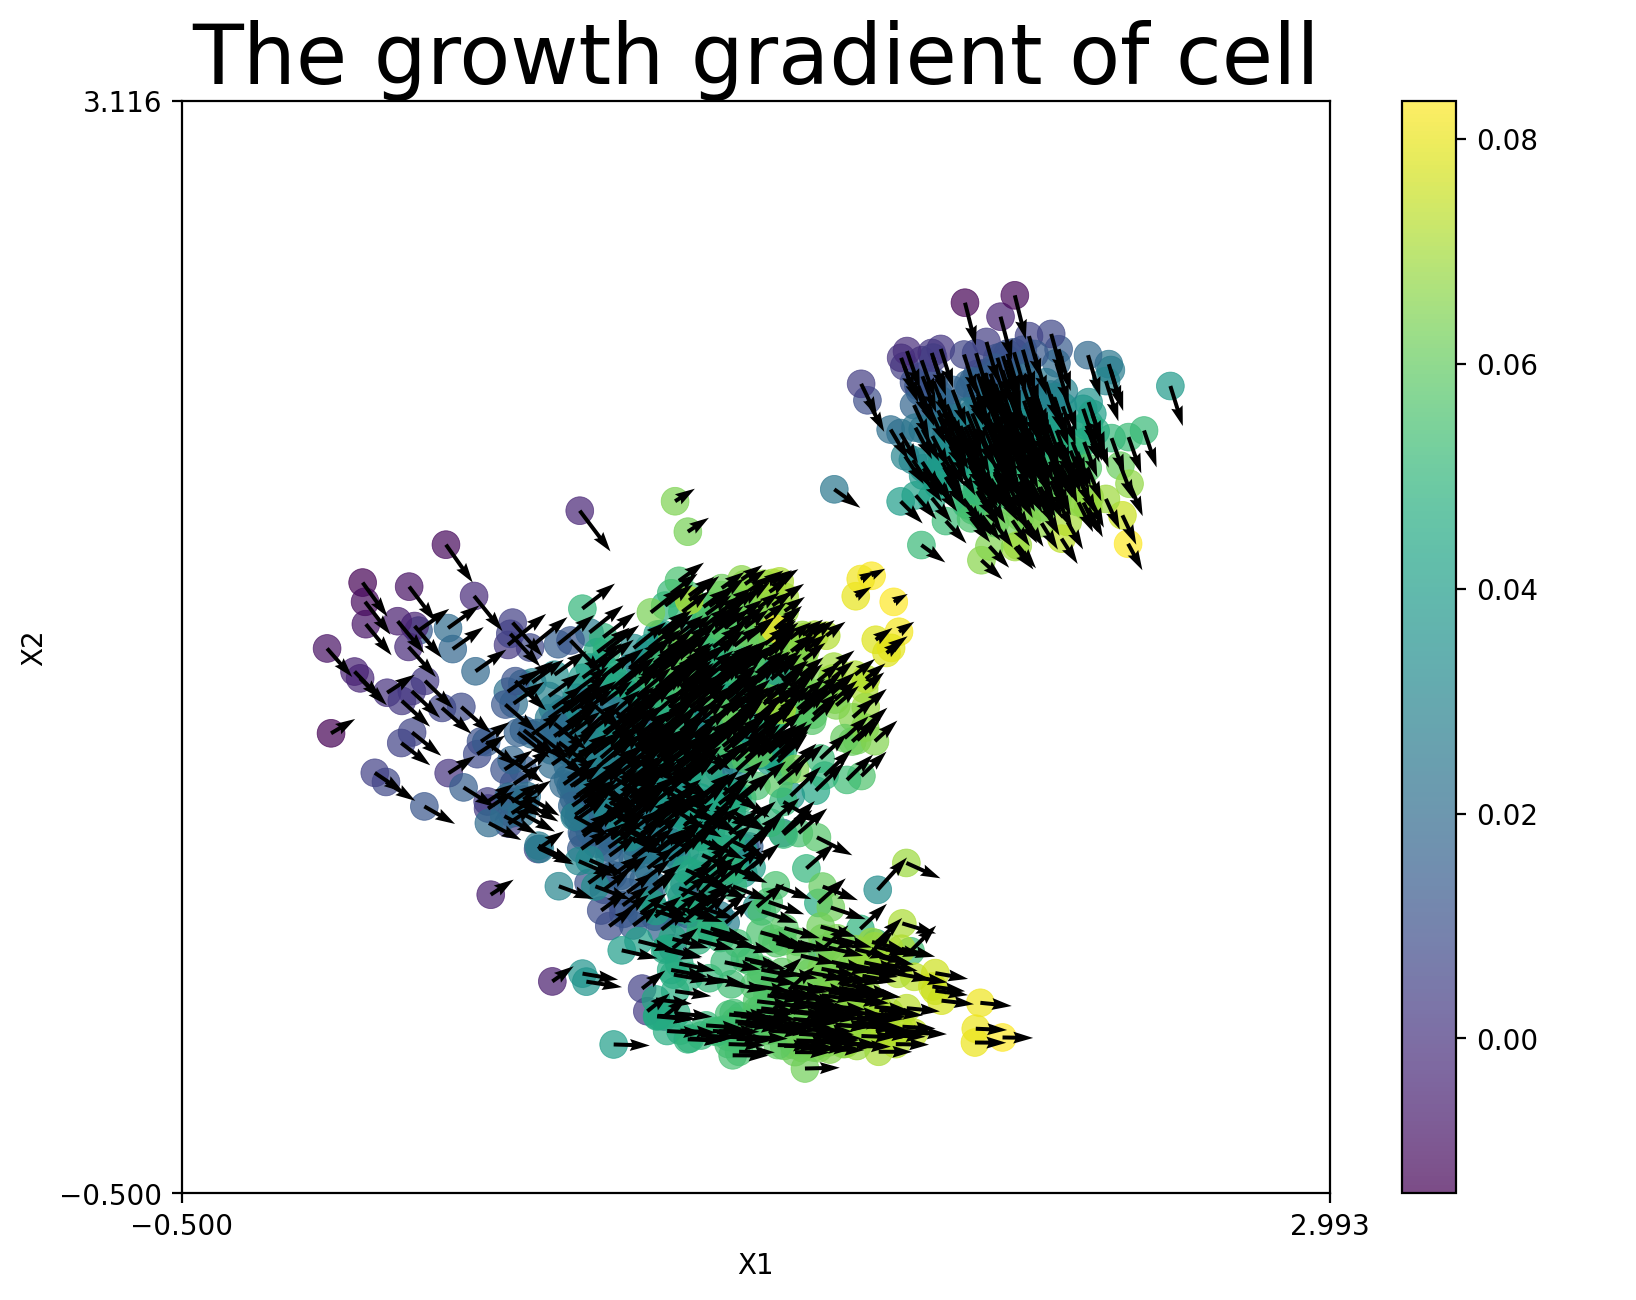

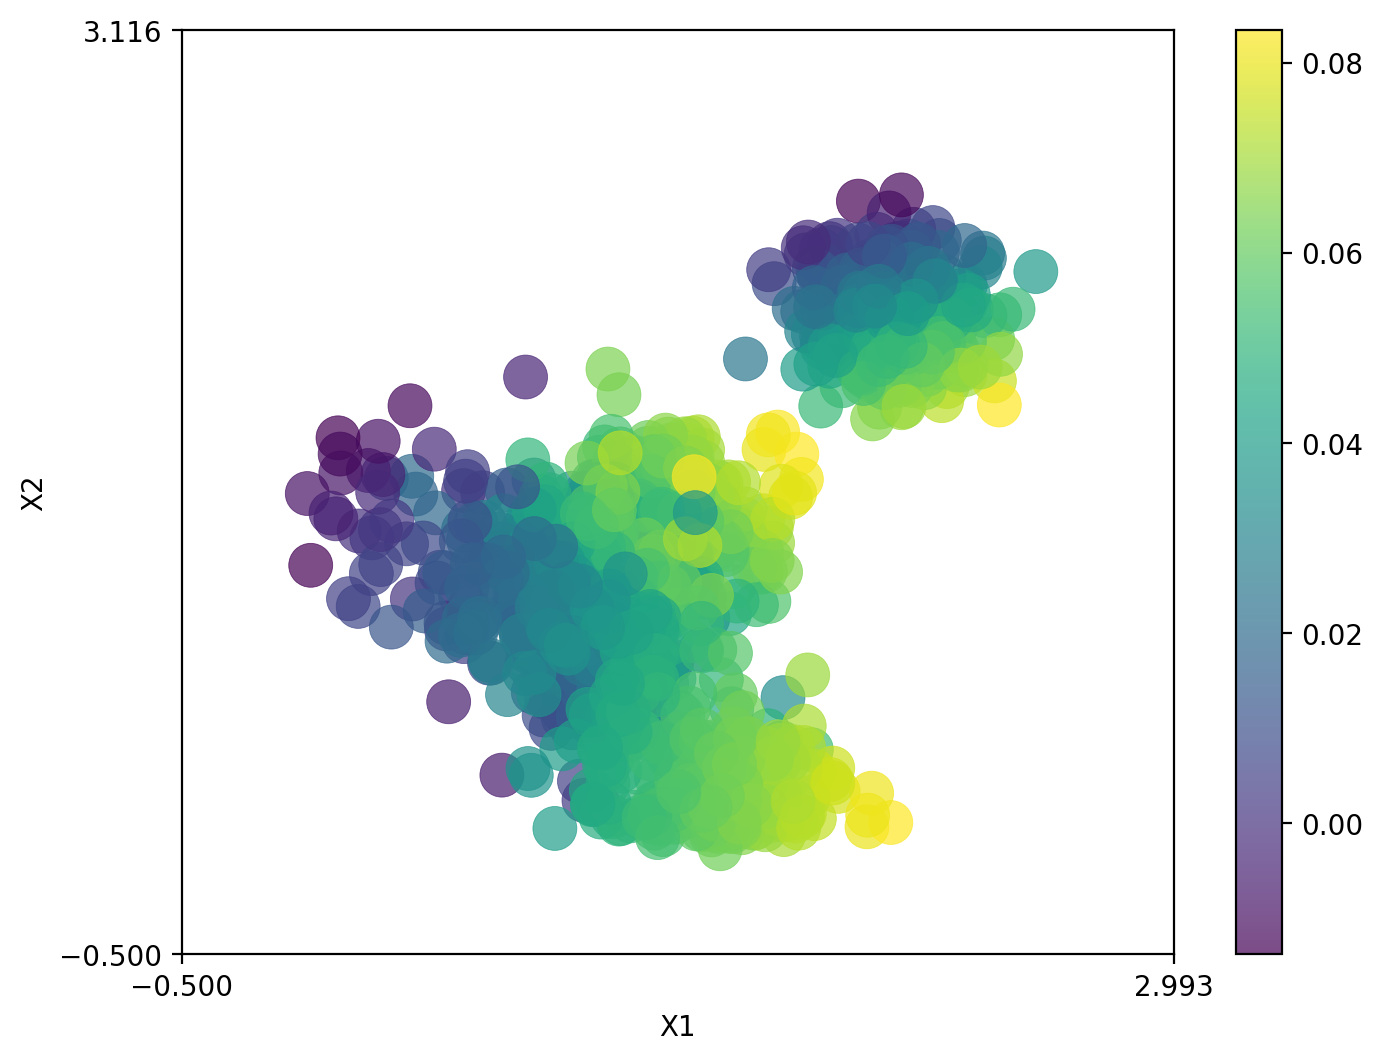

In [4]:
plot_2d(func,data_train,train_time,integral_time,args,device)  

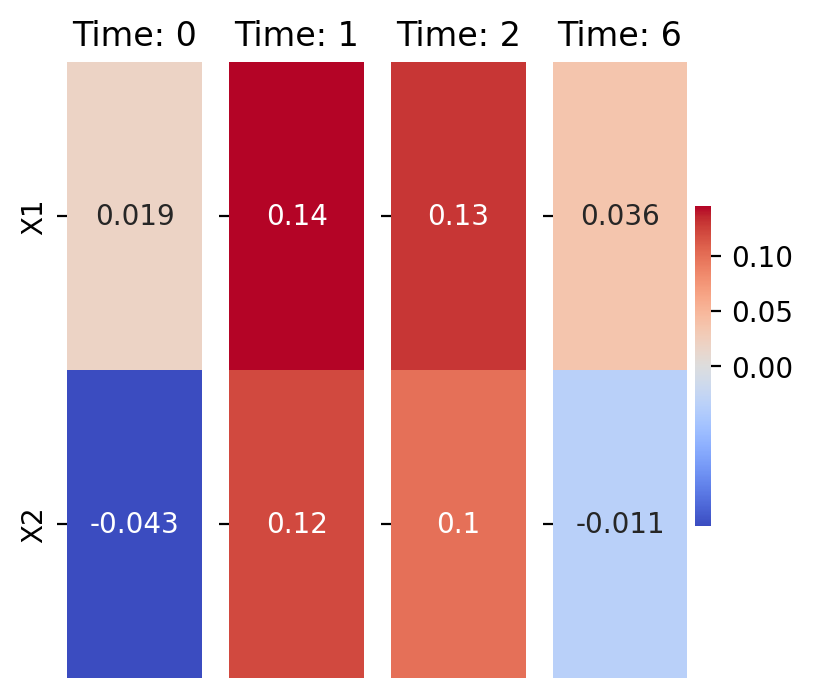

In [5]:
filepath='C:\\Users\\JTliu\\Desktop\\DiffusionOT-main\\Output\\'
plot_grad_g_all(func,data_train,'MISA_Average_grad.pdf',['X1','X2'],filepath,args,device)

## Cell fate landscape

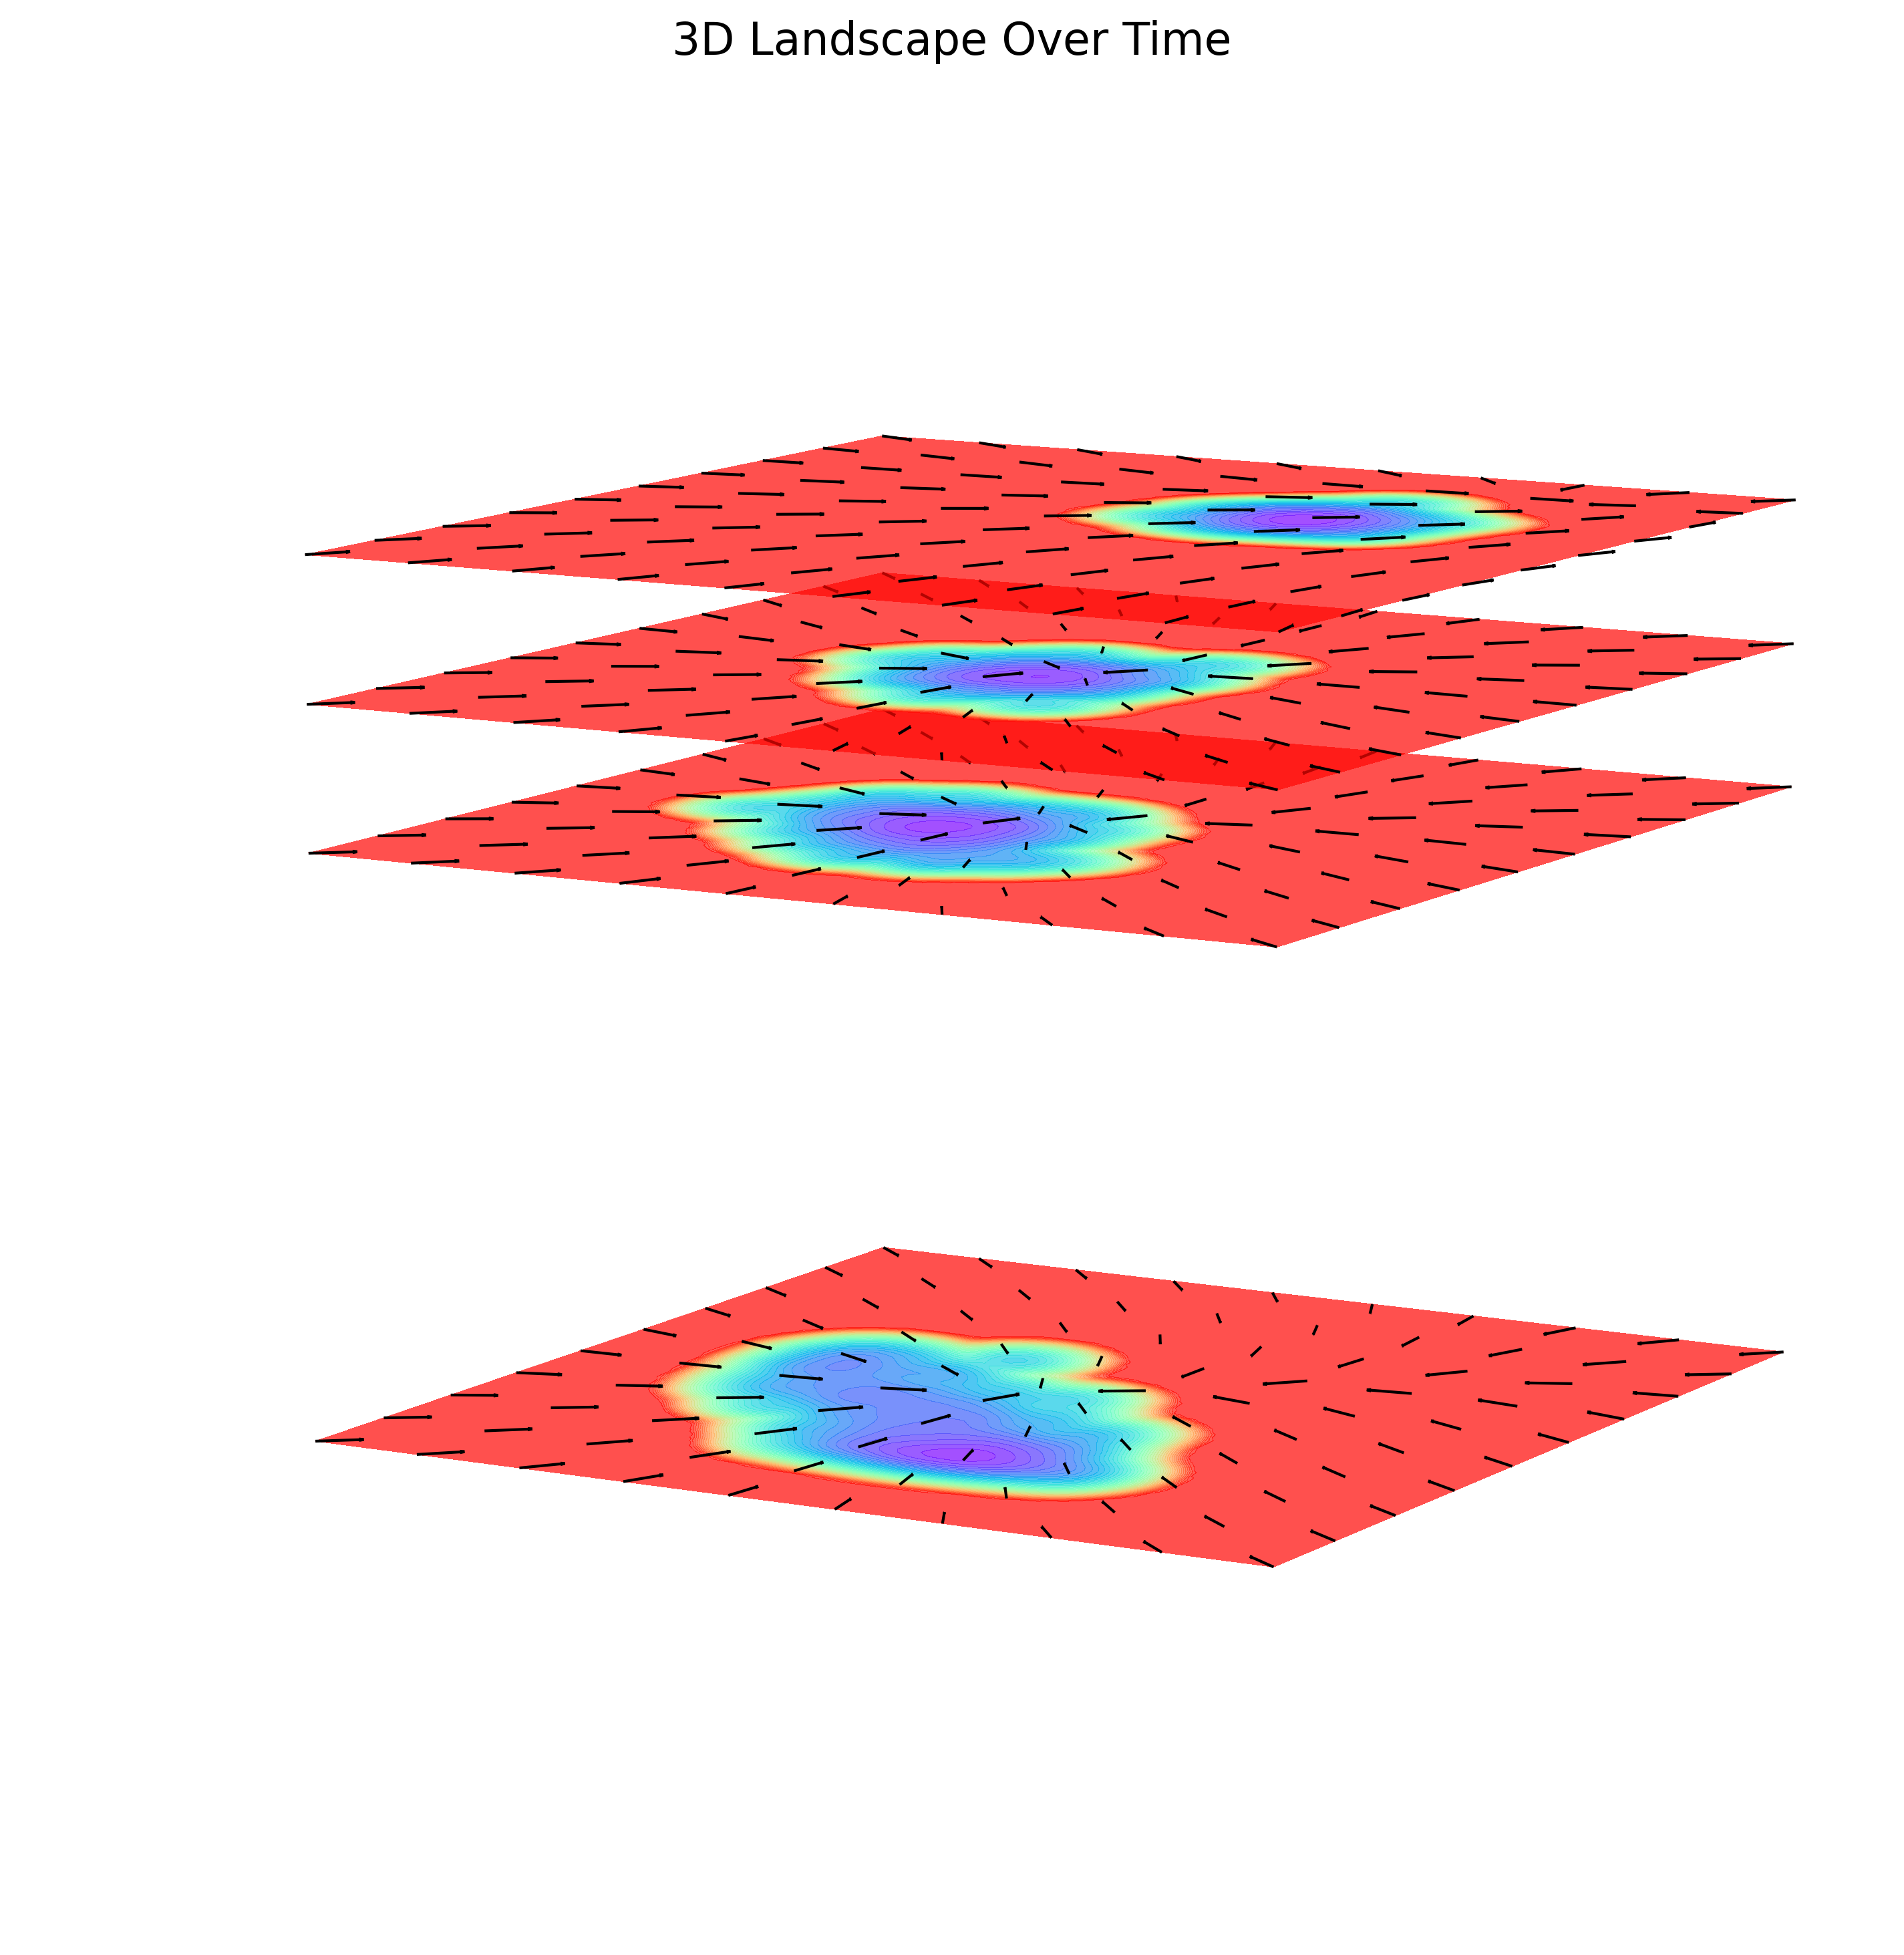

In [6]:
plot_3d_landscape(func,data_train,train_time,integral_time,args,device)

## Inferring the GRNs

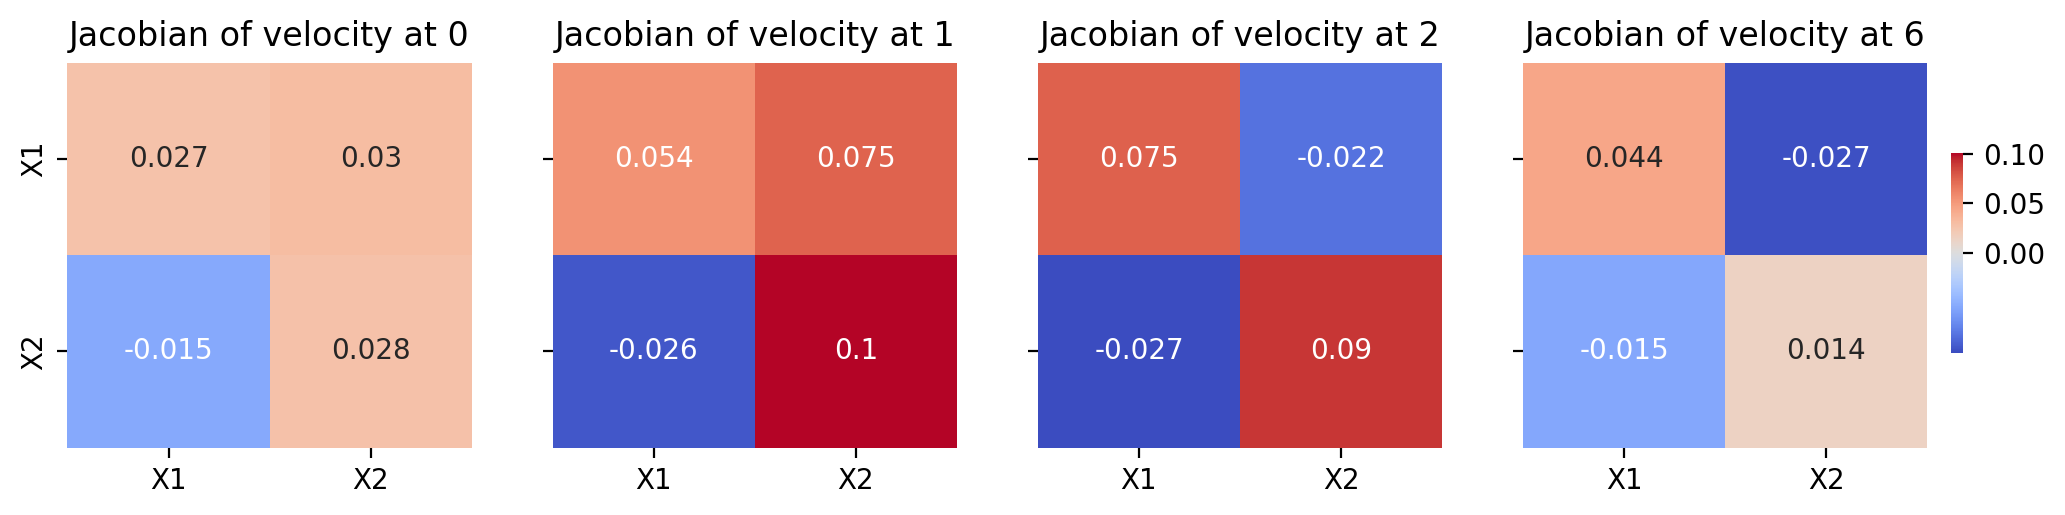

In [7]:
plot_jac_v_all(func,data_train,'MISA_Average_jac.pdf',['X1','X2'],filepath,args,device)

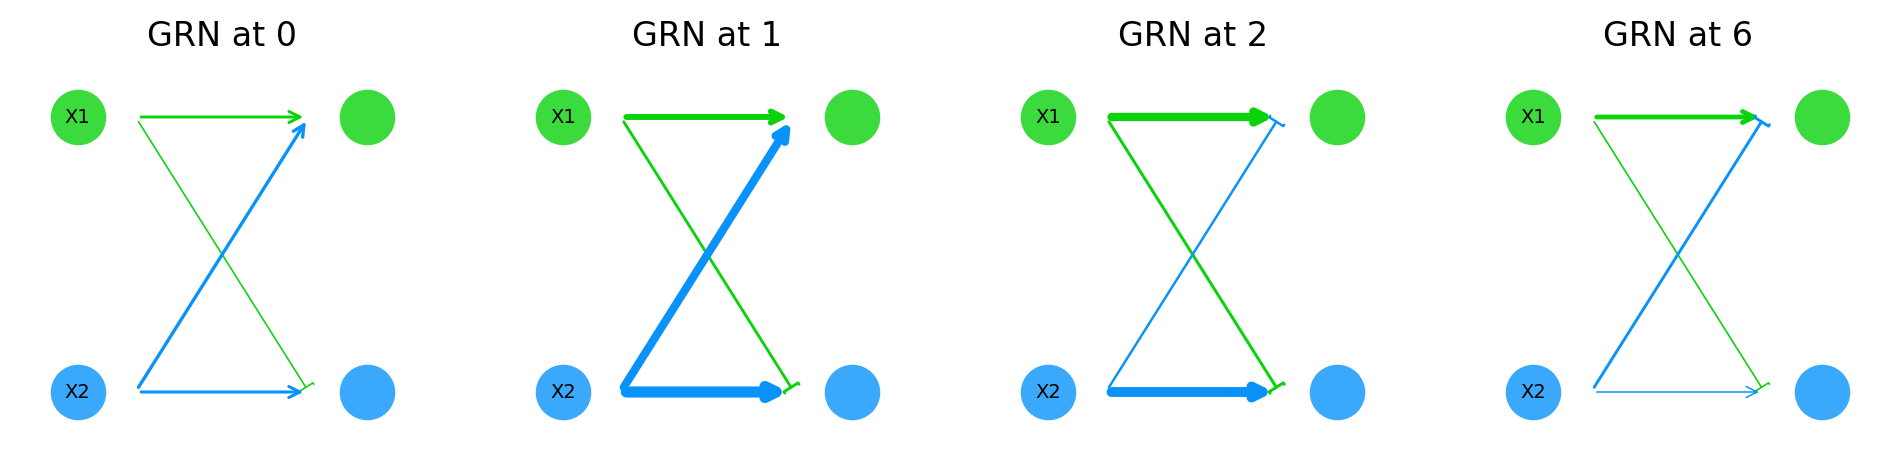

In [8]:
plot_grn_all(func,data_train,'MISA_Average_grn.pdf',['X1','X2'],filepath,args,device,threshold=0.01)